<a href="https://colab.research.google.com/github/Abdalmughith/machine-learning-projects/blob/master/plate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://transfer.sh/Koakc/object_detection_22_10last.zip

In [0]:
!unzip object_detection_22_10last.zip

In [0]:
!nohup python train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/faster_rcnn_inception_v2_pets.config &

nohup: appending output to 'nohup.out'


In [0]:
!tail nohup.out 

INFO:tensorflow:global step 49998: loss = 0.0217 (0.274 sec/step)
I1025 13:46:24.937163 140262287374208 tf_logging.py:115] global step 49998: loss = 0.0217 (0.274 sec/step)
INFO:tensorflow:global step 49999: loss = 0.0183 (0.271 sec/step)
I1025 13:46:25.209553 140262287374208 tf_logging.py:115] global step 49999: loss = 0.0183 (0.271 sec/step)
INFO:tensorflow:global step 50000: loss = 0.0282 (0.277 sec/step)
I1025 13:46:25.488208 140262287374208 tf_logging.py:115] global step 50000: loss = 0.0282 (0.277 sec/step)
INFO:tensorflow:Stopping Training.
I1025 13:46:25.488965 140262287374208 tf_logging.py:115] Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
I1025 13:46:25.489160 140262287374208 tf_logging.py:115] Finished training! Saving model to disk.


In [0]:
rm training/faster_rcnn_inception_v2_pets.config

In [0]:
cd training

In [0]:
!wget https://transfer.sh/cYRr5/faster_rcnn_inception_v2_pets.config

In [0]:
cat faster_rcnn_inception_v2_pets.config

In [0]:
cd /content/object_detection

In [0]:
!curl --upload-file ./inference_graph50000.zip https://transfer.sh/inference_graph50000.zip

https://transfer.sh/2rm5L/inference_graph50000.zip

In [0]:
!python export_inference_graph.py --input_type image_tensor --pipeline_config_path training/faster_rcnn_inception_v2_pets.config --trained_checkpoint_prefix training/model.ckpt-50000 --output_directory inference_graph50000

Instructions for updating:
keep_dims is deprecated, use keepdims instead
W1025 14:00:51.054312 140277464782720 tf_logging.py:125] From ../object_detection/predictors/heads/box_head.py:93: calling reduce_mean (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
W1025 14:00:51.817759 140277464782720 tf_logging.py:125] From ../object_detection/exporter.py:280: get_or_create_global_step (from tensorflow.contrib.framework.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
W1025 14:00:51.822887 140277464782720 tf

In [0]:
import sys
# https://opencv.org/
!pip install  numpy scipy matplotlib pillow scikit-image pandas lxml num2words 
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
!apt-get -qq install libprotobuf-java protobuf-compiler -y
# sys.path.append('/content/models/research')
# sys.path.append('/content/models/research/slim')
# !git clone https://github.com/tensorflow/models.git
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython contextlib2 jupyter matplotlib 


In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.

sys.path.append("..")
from object_detection.utils import ops as utils_ops

# if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
#   raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


In [0]:
%matplotlib inline

In [0]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

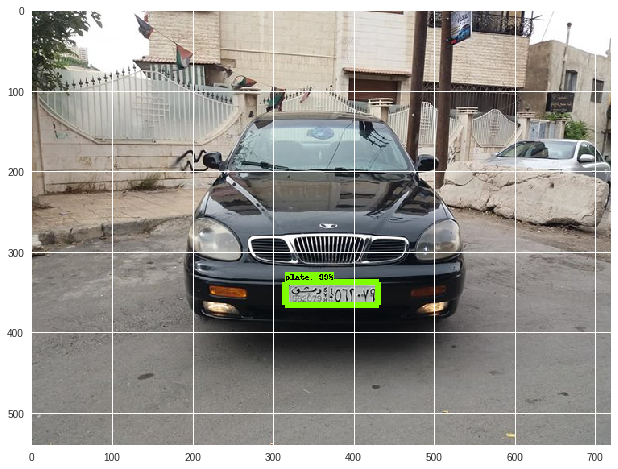

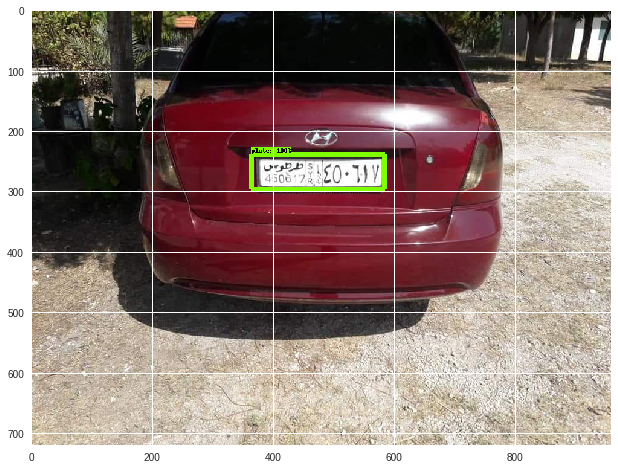

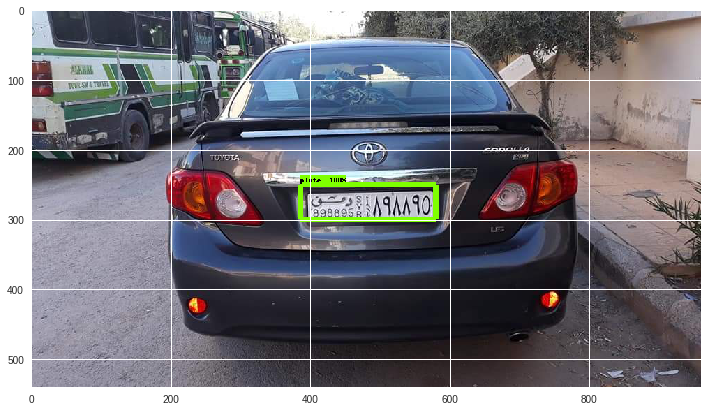

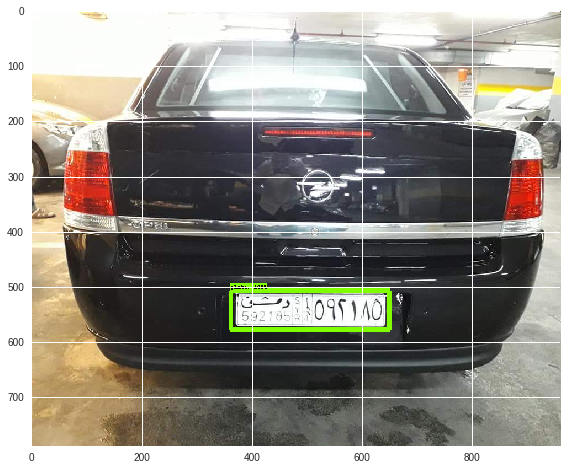

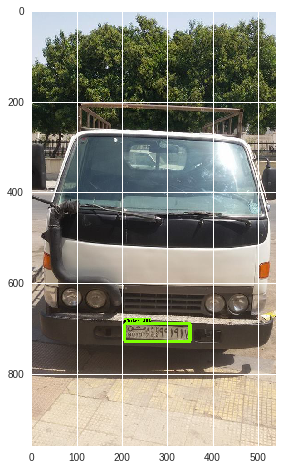

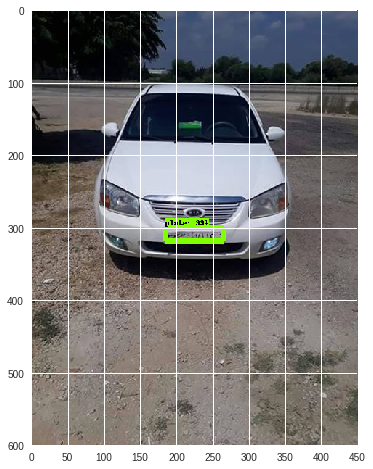

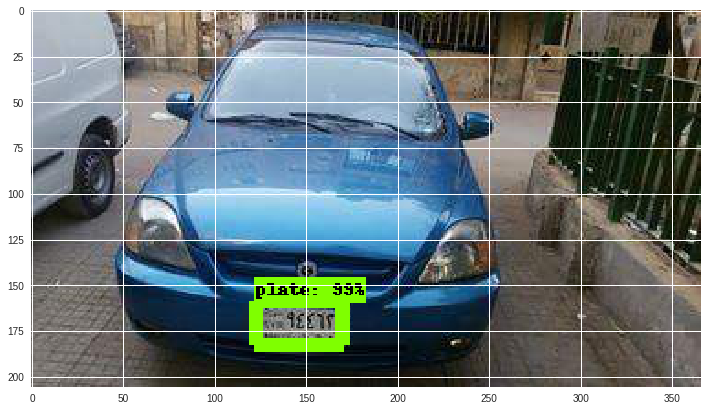

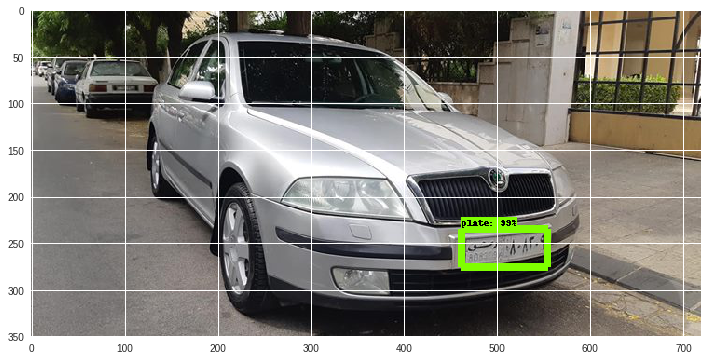

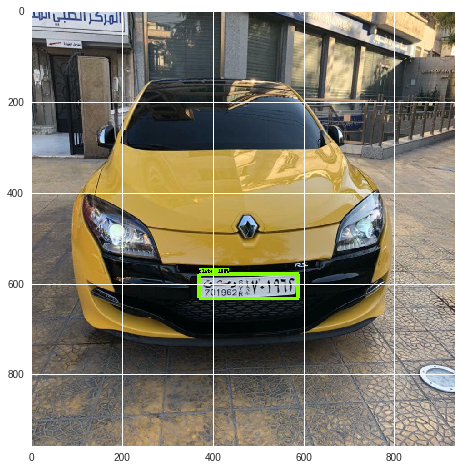

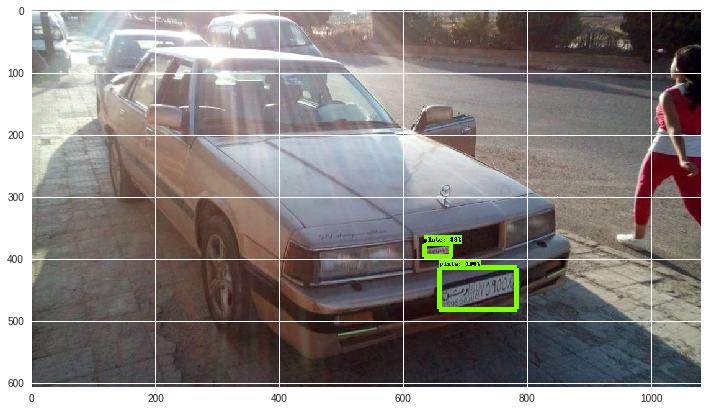

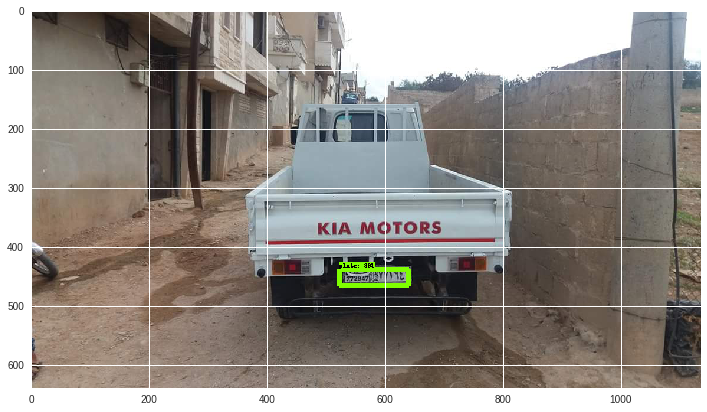

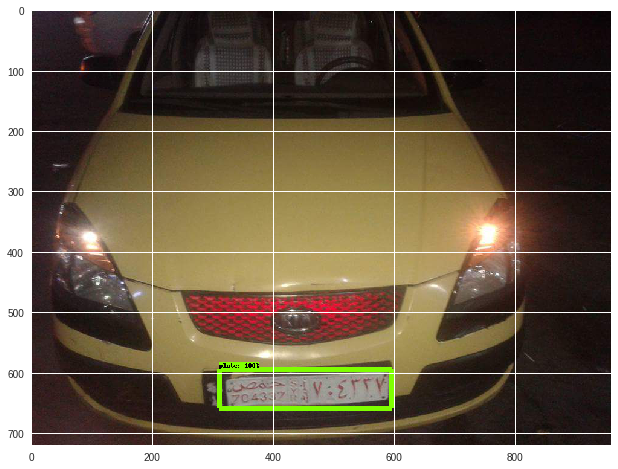

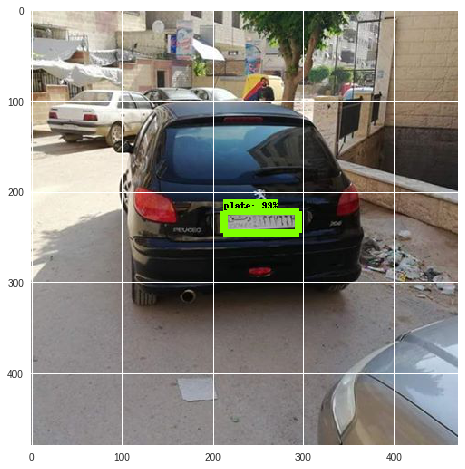

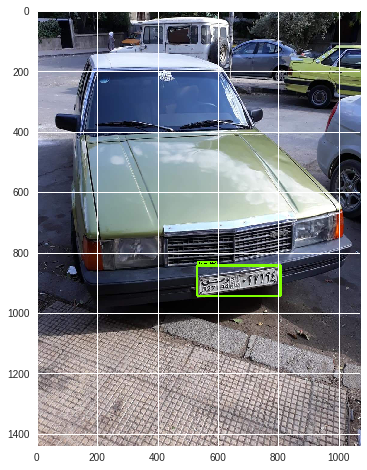

In [0]:
PATH_TO_FROZEN_GRAPH = "inference_graph50000/frozen_inference_graph.pb"
PATH_TO_LABELS = "training/labelmap.pbtxt"
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

PATH_TO_TEST_IMAGES_DIR = 'test_images1'
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
import os
for file in os.listdir(PATH_TO_TEST_IMAGES_DIR):
    if file.endswith(".jpg"):
      image = Image.open(os.path.join(PATH_TO_TEST_IMAGES_DIR ,file))
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      output_dict = run_inference_for_single_image(image_np, detection_graph)
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index,
          instance_masks=output_dict.get('detection_masks'),
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)